# Import Packages

In [1]:
from packages import *

# Read Dataset

In [2]:
names_df = pd.read_csv('name_gender.csv')
names_df.head()

,name,gender
0,Aaban&&,M
1,Aabha*,F
2,Aabid,M
3,Aabriella,F
4,Aada_,F


# Preprocess Data

In [3]:
# check if any first name contains more than 1 word
for i in names_df['name']:
    if(len(i.split())>1):
        print(i)

In [3]:
def preprocess(names_df, train=True):
    # Lowercase
    names_df['name'] = names_df['name'].str.lower()

    # Remove accent
    names_df['name'] = names_df['name'].apply(lambda x:unidecode.unidecode(x))
    
    # Remove non-alphabet characters
    names_df['name'] = [
        "".join([
            char
            for char in name
            if char.isalpha()==True
        ])
        for name in names_df['name']
    ]
    
    # drop duplicate rows
    names_df = names_df.drop_duplicates().reset_index(drop=True)
    
    # drop NaN
    names_df = names_df.dropna().reset_index(drop=True)
    
    # get name with maximum no. of characters (to be used for padding)
    name_length = max(names_df['name'].map(len))

    # Split individual characters
    names_df['name'] = [list(name) for name in names_df['name']]

    # Pad names with spaces to make all names same length
    name_length = name_length + 5
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    # Encode Characters to unique numbers
    # we encode ‘ ’ (space) to 0, ‘a’ to 1, ‘b’ to 2, and so on
    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]
    
    # Encode Gender to Numbers
    if train:
        names_df['gender'] = [
            0 if gender=='F' else 1
            for gender in names_df['gender']
        ]
    
    return names_df

names_df = preprocess(names_df)
names_df.head()

,name,gender
0,"[1.0, 1.0, 2.0, 1.0, 14.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[1.0, 1.0, 2.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[1.0, 1.0, 2.0, 9.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[1.0, 1.0, 2.0, 18.0, 9.0, 5.0, 12.0, 12.0, 1....",0
4,"[1.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [4]:
names_df.shape

(95025, 2)

In [5]:
names_df['gender'].value_counts()

0    60304
1    34721
Name: gender, dtype: int64

# Train-test split

In [8]:
# Split the data into 80% training and 20% testing.
X = np.asarray(names_df['name'].values.tolist())
y = np.asarray(names_df['gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

print('Training Class Distribution:',Counter(y_train))
print('Testing Class Distribution:',Counter(y_test))

Training Class Distribution: Counter({0: 48243, 1: 27777})
Testing Class Distribution: Counter({0: 12061, 1: 6944})


# Modeling

In [6]:
# Define model
def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential()
    
    # Embedding layer: to “embed” each input character’s encoded number into a dense 256 dimension vector
    model.add(Embedding(num_alphabets, embedding_dim, input_length=name_length))
    
    # Bidirectional LSTM layer: read the sequence of character embeddings from the previous step and output a single vector representing that sequence
    model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)))
    
    # Final Dense layer: to output a single value close to 0 for ‘F’ or close to 1 for ‘M’
    model.add(Dense(1, activation="sigmoid"))
 
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [7]:
# Instantiate the model
name_length = len(names_df['name'][0])
model = lstm_model(name_length=name_length)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 256)           6912      
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 401,409
Trainable params: 401,409
Non-trainable params: 0
_________________________________________________________________


In [9]:
# callbacks
# EarlyStopping callback to stop training once the model starts to overfit.
es = EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=0)

In [10]:
# assign class weights to handle class imbalance
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.7878863254772713, 1: 1.3683983151528243}

In [11]:
# model training
history = model.fit(X_train,
                    y_train,
                    batch_size = 64,
                    epochs = 30,
                    shuffle = True,
                    validation_split = 0.2,
                    class_weight = class_weights,
                    callbacks = [es])

Epoch 1/30
951/951 [==============================] - 109s 114ms/step - loss: 0.4421 - accuracy: 0.7930 - val_loss: 0.3751 - val_accuracy: 0.8382
Epoch 2/30
951/951 [==============================] - 106s 112ms/step - loss: 0.3654 - accuracy: 0.8388 - val_loss: 0.3547 - val_accuracy: 0.8468
Epoch 3/30
951/951 [==============================] - 107s 112ms/step - loss: 0.3398 - accuracy: 0.8522 - val_loss: 0.3189 - val_accuracy: 0.8636
Epoch 4/30
951/951 [==============================] - 105s 110ms/step - loss: 0.3150 - accuracy: 0.8628 - val_loss: 0.3062 - val_accuracy: 0.8708
Epoch 5/30
951/951 [==============================] - 101s 106ms/step - loss: 0.2912 - accuracy: 0.8743 - val_loss: 0.2922 - val_accuracy: 0.8758
Epoch 6/30
951/951 [==============================] - 102s 107ms/step - loss: 0.2701 - accuracy: 0.8862 - val_loss: 0.2928 - val_accuracy: 0.8765
Epoch 7/30
951/951 [==============================] - 102s 107ms/step - loss: 0.2520 - accuracy: 0.8944 - val_loss: 0.2758 -

In [12]:
# Save the trained model to reuse while serving the web app
model.save('models/BiLSTM_GC.h5')

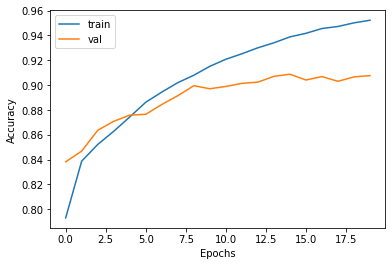

In [13]:
# Plot accuracies vs epoch graph
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

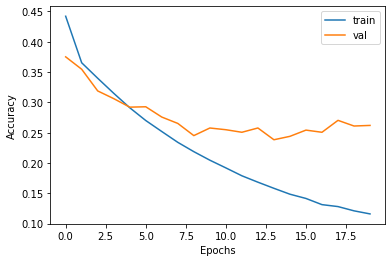

In [14]:
# Plot loss vs epoch graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing

****************************************************************************************************
              precision    recall  f1-score   support

      Female       0.94      0.91      0.93     12061
        Male       0.85      0.90      0.88      6944

    accuracy                           0.91     19005
   macro avg       0.90      0.91      0.90     19005
weighted avg       0.91      0.91      0.91     19005



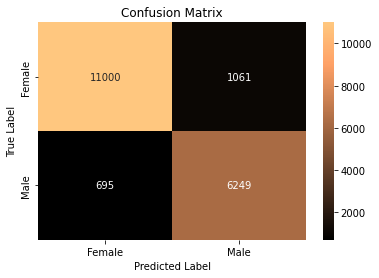

In [15]:
# Display classification report and confusion matrix on test set
def test_report(clf): 
    y_pred = clf.predict(X_test)
    y_pred    = [int(round(i[0],0)) for i in y_pred]
    
    labels = ['Female','Male']
    
    array = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(array, index = labels, columns = labels)
    
    plt.title("Confusion Matrix")
    s = sns.heatmap(df_cm, annot=True, cmap='copper', fmt='g')
    s.set(xlabel='Predicted Label', ylabel='True Label')
    print('*'*100)
    
    print(classification_report(y_test, y_pred, target_names = labels))

test_report(model)